In [ ]:
from vanilla import VanillaGradientExplainer   # 분석기 클래스가 정의된 파일 경로에 맞게 수정
import torchvision.models as models
import torch.nn as nn
import torch
import pandas as pd

# (1) ResNet18 구조 생성
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, 3)    # 클래스 수(예: 정상/폐렴/기타=3)에 맞춰 수정

# (2) 저장된 가중치 불러오기
checkpoint = torch.load('models/best_model_augmented.pth', map_location='cpu')
model.load_state_dict(checkpoint)

# (3) explainer 초기화
explainer = VanillaGradientExplainer(model, device='cpu')


## 1개씩 분석

[DEBUG] '35a60fb3-459a-43a6-9c1f-066578ca5d63' 에 대해 1개 bbox 로드됨


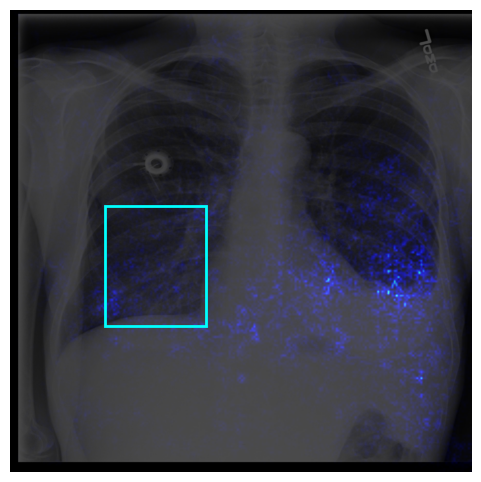

=== XAI와 Ground Truth Bounding Box 겹침 분석 ===
ID  Class        IoU    Precision Recall Intensity
------------------------------------------------------------
0   1            0.090  0.131     0.223  0.049
------------------------------------------------------------
평균 IoU: 0.090
평균 Precision: 0.131
평균 Recall: 0.223


In [ ]:
from PIL import Image

#  이미지 로드
img = Image.open('data/test/1/35a60fb3-459a-43a6-9c1f-066578ca5d63.jpg').convert('RGB')    # 이미지 파일 경로

# 분석 실행
analysis_results = explainer.comprehensive_analysis_with_bbox(
    img, 
    csv_path='stage_2_train_labels.csv',   # 레이블 파일
    image_filename='35a60fb3-459a-43a6-9c1f-066578ca5d63'     # img 로드한 파일명
)

# 시각화
explainer.visualize_gradients_with_bbox(
    img, 
    analysis_results['gradients']['absolute'],
    analysis_results['bounding_boxes'],
    alpha=0.7
)

# 겹침 분석 결과 확인
explainer.print_overlap_analysis(analysis_results['overlap_metrics'])


[DEBUG] '11a355bd-9544-4211-bfa8-451777c1d3c2' 에 대해 2개 bbox 로드됨


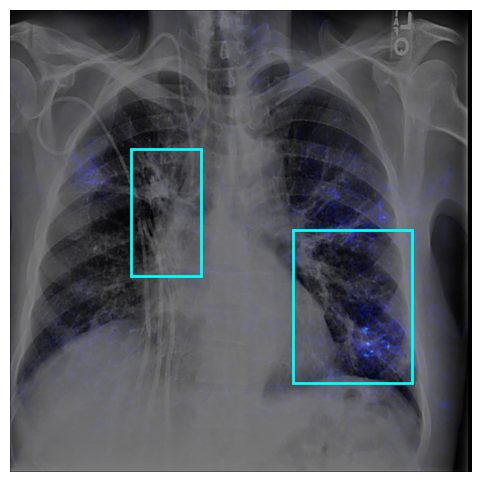

=== XAI와 Ground Truth Bounding Box 겹침 분석 ===
ID  Class        IoU    Precision Recall Intensity
------------------------------------------------------------
0   1            0.232  0.347     0.413  0.070
1   1            0.010  0.013     0.032  0.015
------------------------------------------------------------
평균 IoU: 0.121
평균 Precision: 0.180
평균 Recall: 0.222


In [ ]:
img = Image.open('data/test_preprocessed/1/11a355bd-9544-4211-bfa8-451777c1d3c2.jpg').convert('RGB')  

analysis_results = explainer.comprehensive_analysis_with_bbox(
    img, 
    csv_path='stage_2_train_labels.csv',
    image_filename='11a355bd-9544-4211-bfa8-451777c1d3c2'
)

explainer.visualize_gradients_with_bbox(
    img, 
    analysis_results['gradients']['absolute'],
    analysis_results['bounding_boxes'],
    alpha=0.5
)

explainer.print_overlap_analysis(analysis_results['overlap_metrics'])

[DEBUG] '08f580ca-6c0e-47ca-9759-851b3c0bb397' 에 대해 2개 bbox 로드됨


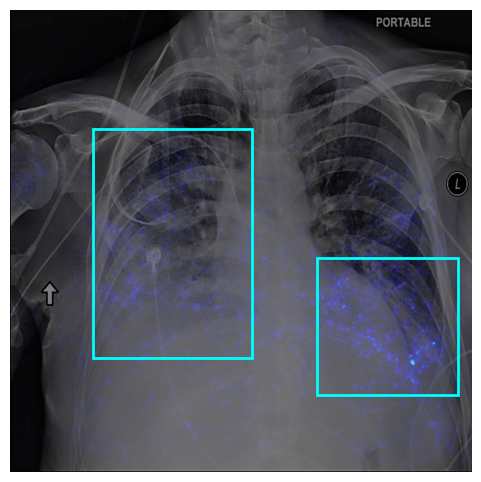

=== XAI와 Ground Truth Bounding Box 겹침 분석 ===
ID  Class        IoU    Precision Recall Intensity
------------------------------------------------------------
0   1            0.251  0.382     0.421  0.097
1   1            0.124  0.299     0.175  0.046
------------------------------------------------------------
평균 IoU: 0.187
평균 Precision: 0.341
평균 Recall: 0.298


In [ ]:
img = Image.open('data/val_preprocessed/1/08f580ca-6c0e-47ca-9759-851b3c0bb397.jpg').convert('RGB')  

analysis_results = explainer.comprehensive_analysis_with_bbox(
    img, 
    csv_path='stage_2_train_labels.csv',
    image_filename='08f580ca-6c0e-47ca-9759-851b3c0bb397'
)

explainer.visualize_gradients_with_bbox(
    img, 
    analysis_results['gradients']['absolute'],
    analysis_results['bounding_boxes'],
    alpha=0.5
)

explainer.print_overlap_analysis(analysis_results['overlap_metrics'])

## 배치분석

In [ ]:
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# explainer 객체가 이미 생성되어 있다고 가정
# 예: explainer = VanillaGradientExplainer(model, device='cpu')

# 분석 결과를 저장할 디렉토리 생성 (없을 경우)
output_dir = 'batch_analysis_results'
os.makedirs(output_dir, exist_ok=True)

# 이미지들이 있는 디렉토리 경로
image_directory = 'data/val/1/'

# 바운딩 박스 CSV 파일 경로
csv_path = 'stage_2_train_labels.csv'

# 모든 이미지 파일 목록 가져오기
image_files = [f for f in os.listdir(image_directory) if f.endswith('.jpg') or f.endswith('.png')]

# 모든 이미지에 대한 결과를 저장할 리스트 초기화
all_overlap_results = []

# 각 이미지에 대해 배치 처리
for image_filename in image_files:
    full_image_path = os.path.join(image_directory, image_filename)
    
    print(f"\n--- {image_filename} 분석 시작 ---")
    
    try:
        # 1. 흉부 X-ray 이미지 로드 (RGB로 변환)
        # ResNet50 모델은 3채널(RGB) 입력을 기대
        img = Image.open(full_image_path).convert('RGB')
        
        # 2. 종합 분석 실행
        # image_filename에서 .jpg 또는 .png 확장자를 제거하여 patientId로 사용
        file_id = os.path.splitext(image_filename)[0]
        
        analysis_results = explainer.comprehensive_analysis_with_bbox(
            img, 
            csv_path=csv_path,
            image_filename=file_id # 확장자가 없는 파일명 사용
        )
        
        # 3. 시각화 (fig, ax 객체를 반환받도록 visualize_gradients_with_bbox 메서드 수정 필요)
        # visualize_gradients_with_bbox 함수가 fig, ax를 반환하도록 수정했다면 아래와 같이 사용
        fig, ax = explainer.batch_visualize_gradients_with_bbox(
            img, analysis_results['gradients']['absolute'],
            analysis_results['bounding_boxes'],
            alpha=0.7
        )
        
        # 4. 시각화 결과를 파일로 저장
        output_image_path = os.path.join(output_dir, f'xai_heatmap_{file_id}.png')
        fig.savefig(output_image_path)
        plt.close(fig) # Matplotlib Figure 객체를 닫아 메모리 누수 방지


        # 5. 겹침 분석 결과 수집 및 임시저장
        overlap_metrics = analysis_results['overlap_metrics']
        
        if not overlap_metrics:
            print(f"'{image_filename}'에 대한 겹침 분석 결과가 없습니다.")
            # 결과가 없는 경우에도 이미지 ID는 포함하여 기록
            all_overlap_results.append({
                'Image_ID': file_id,
                'BBox_ID': 'N/A',
                'Class': 'N/A',
                'IoU': 'N/A',
                'Precision': 'N/A',
                'Recall': 'N/A',
                'Intensity': 'N/A'
            })
        else:
            for metric in overlap_metrics:
                all_overlap_results.append({
                    'Image_ID': file_id,
                    'BBox_ID': metric['bbox_id'],
                    'Class': metric['bbox_class'],
                    'IoU': f"{metric['iou']:.3f}",
                    'Precision': f"{metric['precision']:.3f}",
                    'Recall': f"{metric['recall']:.3f}",
                    'Intensity': f"{metric['bbox_gradient_intensity']:.3f}"
                })
        
        print(f"--- {image_filename} 분석 완료 ---")

    except FileNotFoundError:
        print(f"오류: {full_image_path} 파일을 찾을 수 없습니다. 건너뜁니다.")
    except Exception as e:
        print(f"오류 발생 ({image_filename}): {e}. 이 파일을 건너뜁니다.")



# 6. 모든 이미지에 대한 배치 분석이 완료된 후, 결과를 CSV 파일로 저장
if all_overlap_results:
    df_results = pd.DataFrame(all_overlap_results)
    output_csv_path = os.path.join(output_dir, 'batch_overlap_analysis_summary_90.csv')
    df_results.to_csv(output_csv_path, index=False, encoding='utf-8')
    print(f"\n모든 이미지에 대한 배치 분석 요약 결과가 저장되었습니다: {output_csv_path}")
else:
    print("\n분석된 이미지가 없거나 겹침 분석 결과가 없습니다.")

print("\n모든 이미지에 대한 배치 분석이 완료되었습니다.")


#         # 5. 겹침 분석 결과 확인(저장 안 하고 바로 출력만)
#         explainer.print_overlap_analysis(analysis_results['overlap_metrics'])
        
#         print(f"--- {image_filename} 분석 완료 및 저장: {output_image_path} ---")

#     except FileNotFoundError:
#         print(f"오류: {full_image_path} 파일을 찾을 수 없습니다. 건너뜝니다.")
#     except Exception as e:
#         print(f"오류 발생 ({image_filename}): {e}. 이 파일을 건너뜁니다.")
#         if 'Torch not compiled with CUDA enabled' in str(e):
#              print("CUDA/MPS 관련 오류입니다. lungs_segmentation/inference.py 파일을 수정했는지 확인하세요.")
#              print("models(image.float().cuda()) -> models(image.float().to(model_device))")
#              print("로 변경해야 합니다.")
    
# print("\n모든 이미지에 대한 배치 분석이 완료되었습니다.")



--- 55d5fe58-1dd5-454e-8628-92ef7f2993dc.jpg 분석 시작 ---
[DEBUG] '55d5fe58-1dd5-454e-8628-92ef7f2993dc' 에 대해 2개 bbox 로드됨
--- 55d5fe58-1dd5-454e-8628-92ef7f2993dc.jpg 분석 완료 ---

--- 77c809fd-1fb7-4dae-a0e6-33408425eb92.jpg 분석 시작 ---
[DEBUG] '77c809fd-1fb7-4dae-a0e6-33408425eb92' 에 대해 1개 bbox 로드됨
--- 77c809fd-1fb7-4dae-a0e6-33408425eb92.jpg 분석 완료 ---

--- f7793f41-fe23-4e09-8bef-6394b56bed37.jpg 분석 시작 ---
[DEBUG] 'f7793f41-fe23-4e09-8bef-6394b56bed37' 에 대해 1개 bbox 로드됨
--- f7793f41-fe23-4e09-8bef-6394b56bed37.jpg 분석 완료 ---

--- 81936d3e-4dda-44c0-9de4-66af23839677.jpg 분석 시작 ---
[DEBUG] '81936d3e-4dda-44c0-9de4-66af23839677' 에 대해 2개 bbox 로드됨
--- 81936d3e-4dda-44c0-9de4-66af23839677.jpg 분석 완료 ---

--- 75dbc949-4634-4f9c-b3bb-a8c03747e9e1.jpg 분석 시작 ---
[DEBUG] '75dbc949-4634-4f9c-b3bb-a8c03747e9e1' 에 대해 2개 bbox 로드됨
--- 75dbc949-4634-4f9c-b3bb-a8c03747e9e1.jpg 분석 완료 ---

--- 3817e718-4a42-4d67-a34a-ab1a4b9d52b3.jpg 분석 시작 ---
[DEBUG] '3817e718-4a42-4d67-a34a-ab1a4b9d52b3' 에 대해 1개 bbox 로드됨
--- 3

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# 이미지가 저장된 디렉토리
output_dir = 'batch_analysis_results'

# 파일 목록 가져오기
image_files = [f for f in os.listdir(output_dir) if f.endswith('.png')]

# # 파일 이름을 기준으로 정렬 (예: xai_heatmap_001.png, xai_heatmap_002.png 등)
# image_files.sort()

# 시작할 이미지 번호 (0부터 시작, 예: 0은 첫 번째 이미지)
start_index = 0  # 여기서 원하는 시작 번호를 설정하세요 (예: 10으로 설정하면 11번째 이미지부터 시작)

# 불러올 이미지의 총 개수
num_images_to_display = 32

# 표시할 이미지 파일 경로 목록
display_image_paths = []
for i in range(num_images_to_display):
    if start_index + i < len(image_files):
        display_image_paths.append(os.path.join(output_dir, image_files[start_index + i]))
    else:
        print(f"경고: {start_index + i}번째 이미지가 존재하지 않아 {len(display_image_paths)}개의 이미지만 표시합니다.")
        break

# 5x5 그리드 설정
rows = 4
cols = 8

fig, axes = plt.subplots(rows, cols, figsize=(40, 20)) # 전체 Figure 크기 설정
axes = axes.flatten() # 2D axes 배열을 1D로 평탄화하여 반복문에서 쉽게 사용

# 각 서브플롯에 이미지 표시
for i, img_path in enumerate(display_image_paths):
    try:
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(os.path.basename(img_path), fontsize=6) # 파일명으로 제목 설정
        axes[i].axis('off') # 축 제거
    except Exception as e:
        print(f"이미지 로드 또는 표시 중 오류 발생 ({img_path}): {e}")
        axes[i].set_title("오류", fontsize=8)
        axes[i].axis('off')